In [1]:
# let's see if we can extract pixel scale without using dLux... will be very interesting.
# Gonna look at for a random signal
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [2]:
diameter = 0.125
period = 304e-6
# modifications to the pscale (and hence wavelength range)
wl_unc = 0.1

In [3]:
N = 1024              # number of samples
dx = 0.004 * 10*10**(-9) # wavelength spacing, for ~ 1000 samples in 10 nm
# can just decrease the wavelength spacing...
fs = 1 / dx           # sampling frequency
freqs = np.fft.fftfreq(N, d=dx)

min_wavelength = 565e-9

# Desired frequency band (in Hz)
f_low = 0

max_wavelength = min_wavelength + dx*N

wl_bound = (max_wavelength - min_wavelength)*wl_unc

# should really get a pixel scale dependence thing here but i'm just gonna multiply be pscale min and max for now
max_spec_freq = (np.sqrt(2)/period) * (diameter/(min_wavelength-wl_bound))

low_max_spec_freq = (np.sqrt(2)/period) * (diameter/(max_wavelength+wl_bound))

f_high = 4*max_spec_freq

In [4]:
key = jr.PRNGKey(15)

# Create a complex array of zeros
spectrum = np.zeros(N, dtype=np.complex64)

# Get indices of freqs within band (positive freqs only)
band_mask = (freqs >= f_low) & (freqs <= f_high)

# Random amplitudes and phases
amp_key, phase_key = jr.split(key)
random_amplitudes = jr.normal(amp_key, shape=(N,)) * band_mask
random_phases = jr.uniform(phase_key, shape=(N,), minval=0.0, maxval=2 * np.pi)

# Assign complex values
spectrum = random_amplitudes * np.exp(1j * random_phases)

# Make symmetric to ensure real time-domain signal
# Copy positive freqs into negative side
def make_hermitian(spec):
    spec = spec.at[1:N//2].set(spec[1:N//2])
    spec = spec.at[-(N//2)+1:].set(np.conj(spec[1:N//2][::-1]))
    return spec

spectrum = make_hermitian(spectrum)


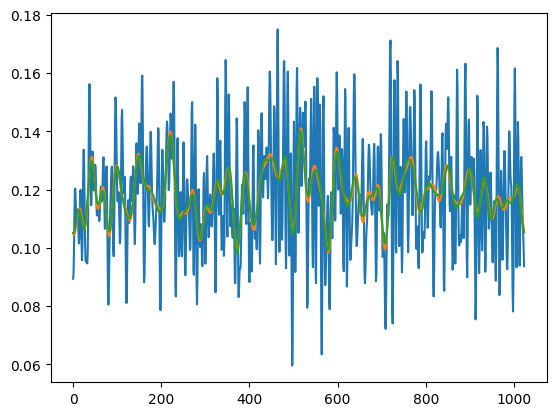

In [5]:
signal = np.fft.ifft(spectrum).real
spectrum_filtered = spectrum.at[np.abs(freqs) > max_spec_freq].set(0)
spectrum_filtered_low = spectrum.at[np.abs(freqs) > low_max_spec_freq].set(0)
signal_filtered = np.fft.ifft(spectrum_filtered).real
signal_filtered_low = np.fft.ifft(spectrum_filtered_low).real

if np.min(signal) <= 0:
    signal_filtered += -2*np.min(signal)
    signal_filtered_low += -2*np.min(signal)
    signal += -2*np.min(signal)

plt.plot(signal)
plt.plot(signal_filtered)
plt.plot(signal_filtered_low)
plt.show()

In [6]:
wavelengths = np.linspace(min_wavelength, max_wavelength, N)

nyquist_sample_interval = 1/(2*max_spec_freq)

sample_interval = 0.4*nyquist_sample_interval #quarter nyquist

n_wavelengths_sample = int(np.ceil((max_wavelength-min_wavelength+2*wl_bound)/sample_interval))

wavelengths_sample = np.linspace(min_wavelength - wl_bound, max_wavelength + wl_bound, n_wavelengths_sample)

weights_initial = np.ones(n_wavelengths_sample) # log weights, but init at 1

flux = 40*(2.909*10**7)*(4/11)

difference = np.pi * 0.348
flux_renorm = flux #/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal)

source_filtered = dl.PointSource(wavelengths, flux=flux_renorm, weights=signal_filtered)

source_model = dl.PointSource(wavelengths_sample, flux=flux_renorm, weights=weights_initial)

wf_npixels = 128 # 128 lowest power of 2 necessary

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 128
assumed_pixel_scale = 0.375

# modifying the pixel scale by some random shift.
ps_shift = jr.uniform(key, minval=1-0.05*wl_unc, maxval=1+0.05*wl_unc)
psf_pixel_scale = assumed_pixel_scale * ps_shift
oversample = 2 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

# need an 'optics model' with assumed pixel scale
optics_model = dl.AngularOpticalSystem(wf_npixels, diameter, layers, psf_npixels, assumed_pixel_scale, oversample)

center_wl = 585e-9

telescope = dl.Telescope(optics, source)
telescope_filtered = dl.Telescope(optics, source_filtered)
telescope_model = dl.Telescope(optics_model, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_filtered = dlT.SideLobeTelescope(telescope_filtered, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

# model sure to include our assumed pixel scale
sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
sidelobe_filtered_raw = sidelobescope_filtered.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample=oversample)

sidelobe_poisson = jr.poisson(key, sidelobe_raw)

print(ps_shift)

Model time: 15.8541 seconds.
Model time: 15.9271 seconds.
1.0002778


In [7]:
weights_path = 'telescope.source.spectrum.weights'

parameters = [weights_path]

# initial guess for weights, uniform ones!
#model = sidelobescope.set(weights_path, np.ones(n_lambda)/n_lambda)
# new oversampled model
model = sidelobescope_model

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.5)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [8]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    # LOG WEIGHTS OPTIMISATION: THIS MAKES IT SOOOO MUCH BETTER!!!
    log_weights = model.get(weights_path)
    weights = np.exp(log_weights)
    model = model.set(weights_path, weights)
    out = model.model_sidelobes(center_wavelength = center_wl, assumed_pixel_scale = assumed_pixel_scale, downsample = oversample)
    #return np.sum((data-out)**2)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [9]:
losses, models_out = [], []
n_iter = 150
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # just do log weight optimisation
        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/150 [00:00<?, ?it/s]

Model time: 3.8062 seconds.


Log Loss: 4.696: 100%|██████████| 150/150 [01:06<00:00,  2.26it/s]


In [10]:
model_log_weights = models_out[-1].weights
model_weights = np.exp(model_log_weights)
final_model = models_out[-1].set(weights_path, model_weights)
model_psf = final_model.model_sidelobes(center_wavelength = center_wl, downsample=oversample)

# extra wavelengths
N_extra = int(np.ceil(wl_bound/dx))
wl_extra_bound = N_extra*dx
wavelengths_extra = np.linspace(min_wavelength - wl_extra_bound, max_wavelength + wl_extra_bound, N + 2*N_extra)


Model time: 4.4157 seconds.


In [13]:
def sinc_interp(xi, x, y, sample_interval):
    # xi: new points, x: original, y: filtered signal
    sinc_matrix = np.sinc((xi[:, None] - x[None, :]) / sample_interval)
    return sinc_matrix @ y  # shape: (len(xi),)

import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=4, foreground='k'), pe.Normal()]

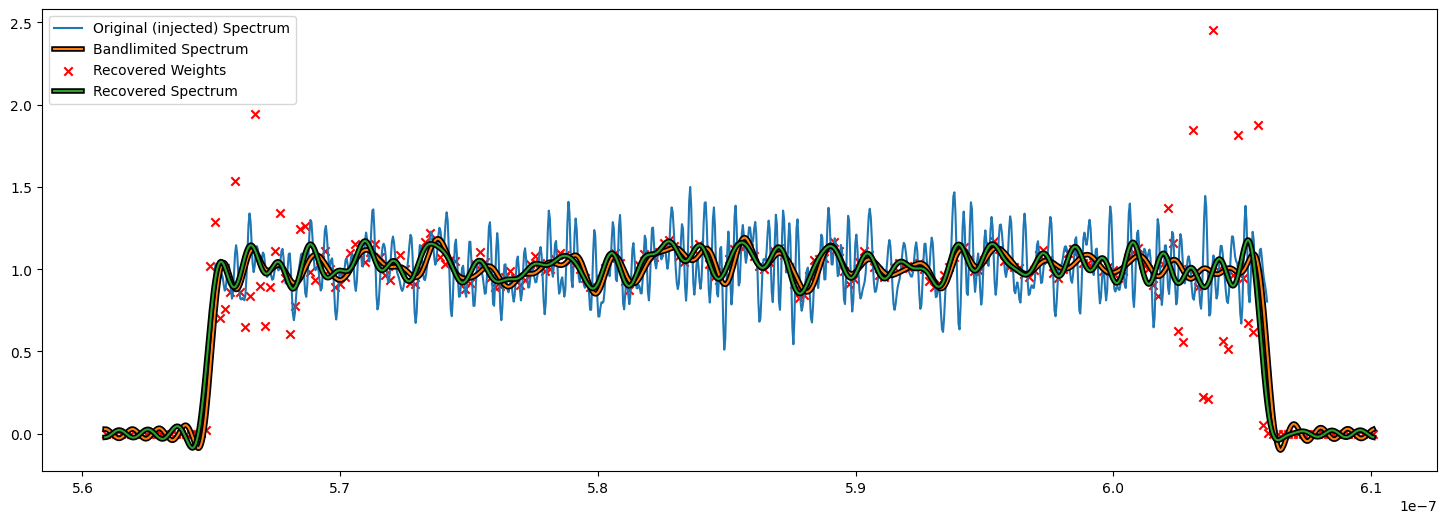

In [14]:
weights_reconstructed = sinc_interp(wavelengths_extra, wavelengths_sample, model_weights, sample_interval)

weights_r_ft = np.fft.fft(weights_reconstructed)

freqs_reconstructed = np.fft.fftfreq(N + 2*N_extra, d=dx)

# just realised sample rate is actually sample interval, not a rate
signal_filtered_ft = np.fft.fft(signal_filtered)

signal_extra = np.pad(signal, (N_extra, N_extra), mode='constant', constant_values=0)
signal_extra_ft = np.fft.fft(signal_extra)

alpha = low_max_spec_freq/max_spec_freq
# low max spec freq is goated
# 0.8 with 100 exposures characterises the middle well? yes.. even more so for lower alpha.
# sometimes really good even for alpha=1!! very exciting. This is very. VERY. VERY COOL!
# above was for 4x nyquist... how about 2x nyquist?
# oh my golly goodness even with a mere 2x nyquist we're recovering it very well. whats going on
# although can be iffy.. (works very well upto 0.9 but by 1 its a bit weird) gonna try 2.5x nyquist.
# 2.5 seems to work well upto 0.97x nyquist. probably where noise comes in too much
# wow this is cool though.
# trying to 'cheat' almost and go to 1.0 nyquist sampling... doesn't work out too well.
# 2.5x nyquist is common in science though I believe. and it works well here.
# 0.97 may have been an illusion, reality is that there are appx no freqs between 0.9 and 0.98 = 1.

weights_r_ft_filtered = weights_r_ft.at[np.abs(freqs_reconstructed) > alpha*max_spec_freq].set(0)

weights_r_filtered = np.fft.ifft(weights_r_ft_filtered).real

#bandlimited_extra = sinc_interp(wavelengths_extra, wavelengths, signal_filtered_filter2)
signal_extra_ft_filtered = signal_extra_ft.at[np.abs(freqs_reconstructed) > alpha*max_spec_freq].set(0)
signal_extra_filtered = np.fft.ifft(signal_extra_ft_filtered).real

#plt.plot(wavelengths, weights_reconstructed)
#plt.plot(wavelengths, signal_filtered/np.max(signal_filtered))
#plt.plot(wavelengths_sample, 2.3*model_weights/np.max(model_weights))
beta = 1.005
plt.figure(figsize=(18,6))
plt.plot(wavelengths, signal/np.median(signal_extra_filtered), label='Original (injected) Spectrum')
plt.plot(wavelengths_extra, signal_extra_filtered/np.median(signal_extra_filtered), label='Bandlimited Spectrum', path_effects = path_effects)
plt.scatter(wavelengths_sample, model_weights/np.median(model_weights), marker='x', color='red', label='Recovered Weights')
plt.plot(wavelengths_extra, weights_r_filtered/np.median(weights_r_filtered), label='Recovered Spectrum', path_effects = path_effects, linestyle='-')

#plt.plot(wavelengths_sample, model_weights/np.max(model_weights))
#plt.plot(wavelengths, signal/np.max(signal_filtered))
#plt.ylim(0.5, 1.2)
plt.legend()
plt.show()

In [15]:
x = wavelengths_extra

g = signal_extra_filtered / np.median(signal_extra_filtered)

f = weights_r_filtered / np.median(weights_r_filtered)

s_interval = x[1]-x[0]

def loss_fn_pscale(gamma):
    scaled_x = x * gamma  # compress/stretch f(x)
    f_gamma = sinc_interp(x, scaled_x, f, s_interval)  # resample f at x
    # just gonna do absolute square error, not mean
    # careful, this doesn't involve interpolation of g, but it turns out that's ok for some reason...
    # it's because we're interpolating f to the values of x, which g is already defined on
    return np.mean((f_gamma - g) ** 2)



In [16]:
# 4. Optimise with optax
init_gamma = np.array(1.0)  # starting guess

opt = optax.adam(learning_rate=1e-4)
opt_state = opt.init(init_gamma)

@jax.jit
def update(gamma, opt_state):
    loss, grad = jax.value_and_grad(loss_fn_pscale)(gamma)
    updates, opt_state = opt.update(grad, opt_state)
    gamma = optax.apply_updates(gamma, updates)
    return gamma, opt_state, loss

# 5. Run optimization loop
gamma = init_gamma
gamma_out = []
for i in range(200):
    gamma, opt_state, loss = update(gamma, opt_state)
    gamma_out.append(gamma)
    if i % 100 == 0:
        print(f"Step {i}: gamma = {gamma:.5f}, loss = {loss:.5e}")

Step 0: gamma = 1.00010, loss = 4.31974e-03
Step 100: gamma = 1.00030, loss = 1.24753e-03


0.0025629997


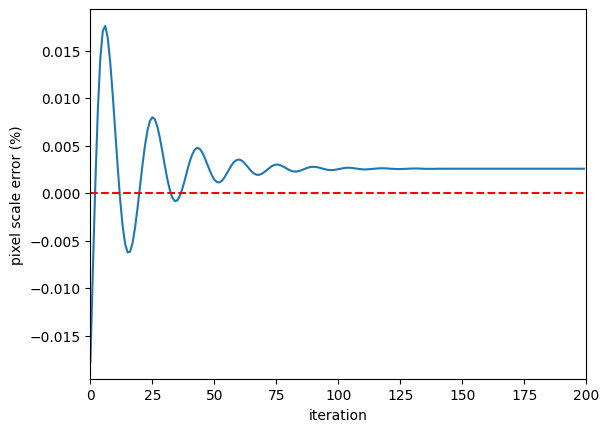

In [17]:
print(100*(np.array(gamma_out[-1])-ps_shift))
plt.plot(range(200), 100*(np.array(gamma_out) - ps_shift))
plt.axhline(0, color='red', linestyle='--')
plt.xlim(0,200)
plt.xlabel('iteration')
plt.ylabel('pixel scale error (%)')
#plt.axhline(psf_pixel_scale/assumed_pixel_scale)
#print(psf_pixel_scale/assumed_pixel_scale)
plt.show()

In [18]:
final_spec = sinc_interp(x, x*np.array(gamma_out[-1]), f, s_interval)

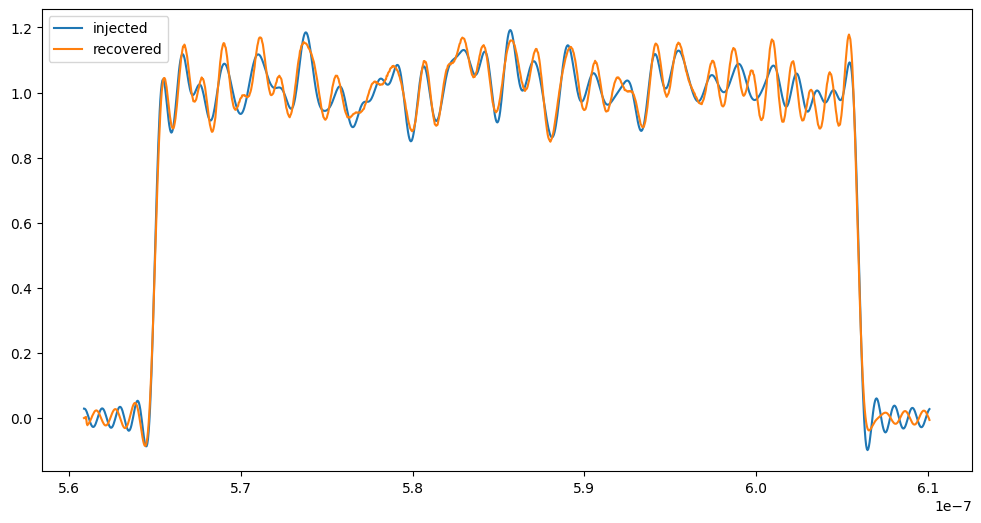

In [19]:
plt.figure(figsize=(12,6))
plt.plot(wavelengths_extra, g, label='injected')
plt.plot(wavelengths_extra, final_spec, label='recovered')

plt.legend()
plt.show()
# very cool how the pixel scale error is so low even though the spectra are totally scuffed.
# errors seem to average out

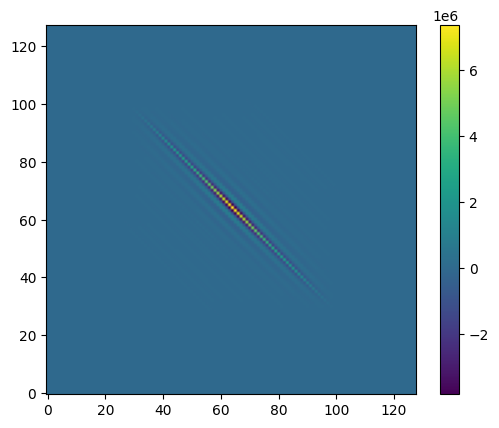

In [33]:
otf = np.fft.fft2(sidelobe_poisson)
plt.imshow(np.fft.fftshift((otf.real)), origin='lower')
plt.colorbar()
plt.show()

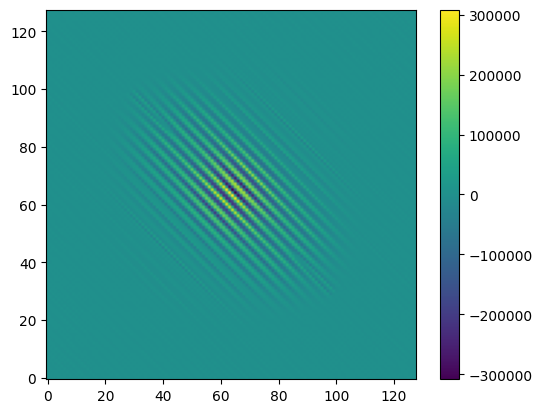

In [32]:
plt.imshow(np.fft.fftshift((otf.imag)),origin='lower')
plt.colorbar()
plt.show()